# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/TRAIN.csv')
test = pd.read_csv('data/TEST.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print('train, test, sample_submission shapes')
print(train.shape, test.shape, sample_submission.shape)
train.head(5)

train, test, sample_submission shapes
(70000, 13) (30000, 12) (30000, 2)


,id,age,weight,height,sex,stress,doctor,sport,pernicious_1,pernicious_2,ubp,lbp,insomnia
0,0,50.357290,62.0,168,2,1,1,1,0,0,110,80,0
1,1,55.381246,85.0,156,1,3,1,1,0,0,140,90,1
2,2,51.627652,64.0,165,1,3,1,0,0,0,130,70,1
3,3,48.249144,82.0,169,2,1,1,1,0,0,150,100,1
4,4,47.841205,56.0,156,1,1,1,0,0,0,100,60,0


# Data analysis

In [4]:
feat_research = pd.DataFrame(train.isna().sum() / train.shape[0], columns=['train_null_share'])
feat_research['test_null_share'] = test.isna().sum() / test.shape[0]
feat_research['train_dtypes'] = train.dtypes
feat_research['train_mean'] = train.mean()
feat_research['test_mean'] = test.mean()

feat_research

,train_null_share,test_null_share,train_dtypes,train_mean,test_mean
id,0.0,0.000000,int64,49972.419900,50062.686900
age,0.0,0.000000,float64,53.302850,53.266334
weight,0.0,0.000000,float64,74.205690,74.120615
height,0.0,0.000000,int64,164.359229,164.322267
sex,0.0,0.000000,int64,1.349571,1.353733
stress,0.0,0.000000,int64,1.366871,1.368033
doctor,0.0,0.000000,int64,1.226457,1.222700
sport,0.0,0.096567,int64,0.803729,0.805926
pernicious_1,0.0,0.101000,int64,0.088129,0.087838
pernicious_2,0.0,0.101033,int64,0.053771,0.054470


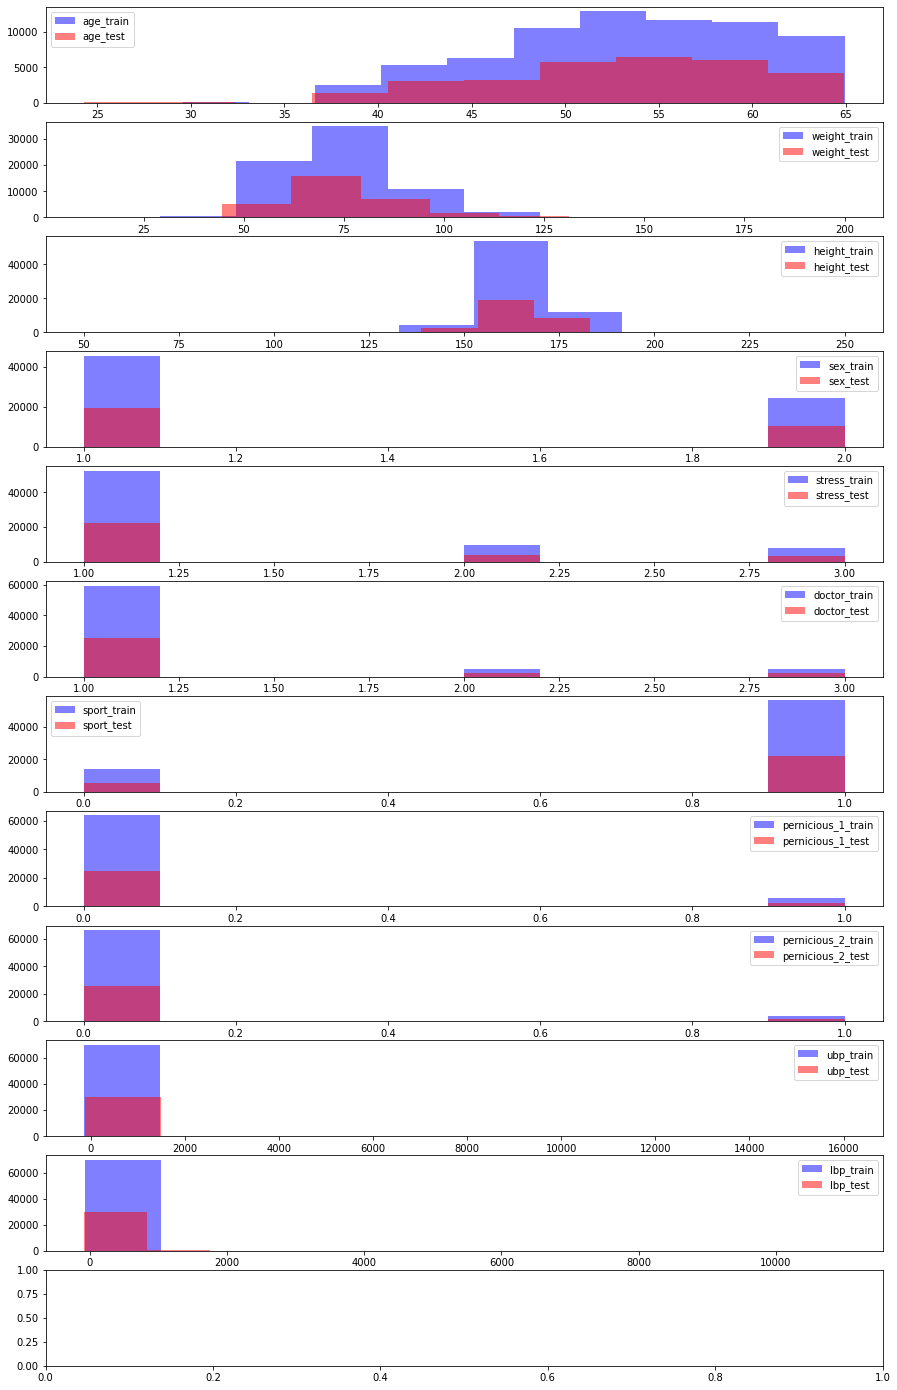

In [5]:
# data distribution 

fig, ax = plt.subplots(len(train.columns)-1, 1)
fig.set_figheight(25)
fig.set_figwidth(15)


for i in range(1, len(test.columns)):
    feat = train.columns[i]
    ax[i-1].hist(train[feat], label=feat+'_train', alpha=0.5, color='blue')
    ax[i-1].hist(test[feat], label=feat+'_test', alpha=0.5, color='red')
    ax[i-1].legend()

plt.show()

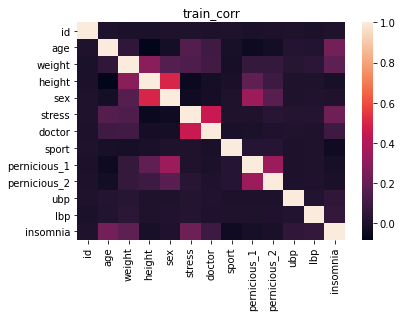

In [6]:
# train correlation matrix

sns.heatmap(train.corr(), annot=False)
plt.title('train_corr')
plt.show()

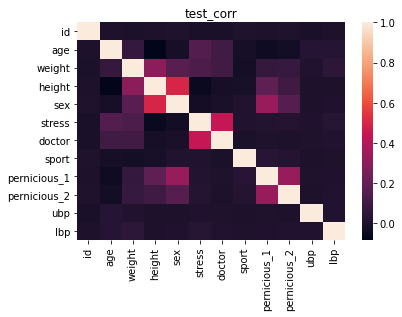

In [7]:
# test correlation matrix

sns.heatmap(test.corr())
plt.title('test_corr')
plt.show()

# Data engineering

Drop less correlated with target

In [8]:
to_drop = ['id', 'sex', 'pernicious_1', 'pernicious_2', 'height']
train = train.drop(columns=to_drop)
test = test.drop(columns=to_drop)

Process nulls

In [9]:
# fix nulls

# pernicious_1 & pernicious_2 correelate with *sex* a little
# so fill nulls with regard to it:
# 1 for *sex* == 2 and 0, otherwise

# pernicious_1_nan_male = np.where((np.isnan(test['pernicious_1']) & (test['sex']==2)),
#                                   1,
#                                   test['pernicious_1'])
# test['pernicious_1'] = pernicious_1_nan_male
# test['pernicious_1'] = test['pernicious_1'].fillna(0)

# pernicious_2_nan_male = np.where((np.isnan(test['pernicious_2']) & (test['sex']==2)), 
#                                1, 
#                                test['pernicious_2'])

# test['pernicious_2'] = pernicious_2_nan_male
# test['pernicious_2'] = test['pernicious_2'].fillna(0)

# fill in *sport* with median
test['sport'] = test['sport'].median()

In [10]:
# one-hot-encoding categorical features

stress_train_ohe = pd.get_dummies(train['stress'], prefix='stress').drop(columns='stress_3')
stress_test_ohe = pd.get_dummies(test['stress'], prefix='stress').drop(columns='stress_3')

train = train.drop(columns='stress')
test = test.drop(columns='stress')

train = train.join(stress_train_ohe)
test = test.join(stress_test_ohe)

# Training pipeline

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# CatBoost
from catboost import CatBoostClassifier

In [12]:
# train-test split

X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='insomnia'),
                                                  train['insomnia'],
                                                  test_size=0.3,
                                                  random_state=42)

In [13]:
# catboostclassifier gridsearchcv

pipe = Pipeline([('poly', PolynomialFeatures(2)),
                 ('scaler', StandardScaler()),
                 ('cbr', CatBoostClassifier(
                     silent=True,
                     random_seed=42,
                     min_data_in_leaf=3,
                     max_leaves=8,
                     loss_function='Logloss',
                     depth=3)
                 ),
                ])

cbr_par = {'cbr__iterations': [50]}
cbr = CatBoostClassifier(silent=True)
cbr_gscv = GridSearchCV(pipe, cbr_par)
cbr_gscv.fit(X_train, y_train)
cbr_best = cbr_gscv.best_estimator_

print('best params: {}'.format(cbr_gscv.best_params_))
print('logloss on best model: {}'.format(log_loss(y_val, cbr_best.predict_proba(X_val))))

best params: {'cbr__iterations': 50}
logloss on best model: 0.5398458578658173


In [14]:
# best:
# 0.5389289572728002

In [15]:
# feature importances for best model

print(X_train.columns)
cbr_best.steps[2][1].feature_importances_

Index(['age', 'weight', 'doctor', 'sport', 'ubp', 'lbp', 'stress_1',
       'stress_2'],
      dtype='object')


array([ 0.        ,  1.46307575,  0.22706417,  0.        ,  0.        ,
       15.61336193,  1.81841606,  0.        ,  0.        ,  2.06495877,
        1.27170253,  2.39356509,  0.56302998, 14.04036864,  9.12706115,
        1.30239511,  0.50296881,  0.2275472 ,  0.58680522,  0.24542726,
        2.21899333,  0.76176377,  8.86370168,  0.27353107,  0.        ,
        0.        , 12.03979136,  0.62222932,  0.        ,  0.08398939,
        0.        ,  0.44769477,  0.29748856,  2.21222163,  0.20813367,
       14.11406562,  0.99898717,  1.27692899,  2.88784861,  0.        ,
        0.23538861,  1.0094948 ,  0.        ,  0.        ,  0.        ])

### Making a submission 

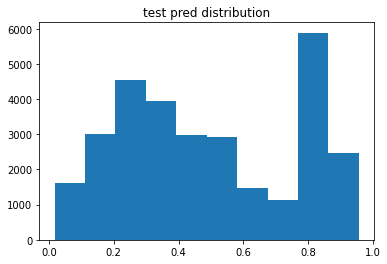

In [16]:
test_pred = cbr_best.predict_proba(test)[:, 1]
# test_pred = pipe.predict(test)

plt.hist(test_pred)
plt.title('test pred distribution')
plt.show()

In [17]:
test_submission = pd.DataFrame(sample_submission['id'])
test_submission['insomnia'] = test_pred
test_submission.head()

,id,insomnia
0,5,0.516386
1,6,0.523428
2,7,0.352994
3,10,0.522201
4,11,0.221410


In [18]:
# check shapes

sample_submission.shape == test_submission.shape

True

In [19]:
test_submission = test_submission.to_csv('out/catboost.csv', index=False)